NomicEmbeddings

Rag with metadata

Human in the loop

--------------------

add database to google api

utilities:   
- patients DB creator

steps:
- Create Agents
- Define tools
- Create graph
- Define Agent Nodes
- Define Tool Node
- Define Edge Logic
- Define the Graph
- show the graph
- Invoke
  
- Human in the loop
- Maximum number of steps
- Helper Utilities

# LLM Agents for Clinical Trial Management

In this notebook, we develop an agent-based system to automate the management and analysis of clinical trial data, ensuring compliance with regulatory standards, and providing comprehensive reports for stakeholders. This pipeline also incorporate human-in-the-loop (HITL) and memory mechanisms to enhance functionality and accuracy.

## Steps and Plan

1. Define the Problem:

Objective: Automate clinical trial data management, analysis, compliance checks, and reporting.

Key Components: Data collection, data analysis, compliance verification, reporting, and human-in-the-loop interventions.

2. Design the Architecture:
**Agents:**
Data Collection Agent: Gathers patient data, trial results, and other relevant information.

Data Analysis Agent: Analyzes the collected data to generate reports on trial outcomes.

Compliance Agent: Ensures all data and processes adhere to regulatory standards.

Reporting Agent: Compiles and presents the analysis findings in comprehensive reports.

Human-in-the-Loop: Integrate a review phase where human experts validate data analysis and compliance checks before final reporting.

Memory: Utilize LangGraph’s memory capabilities to track the progress and history of each trial.

The Clinical Trial Matching Agent is designed to match patients wit	h suitable clinical trials based on their medical history, symptoms, and ongoing treatments. This application helps patients find relevant clinical trials they may be eligible for, improving their chances of accessing new treatments and contributing to medical research.


1. Database Setup
- SQLite Database: Create two databases:
- Patients DB: Stores patient medical history, previous trials, and other relevant data.
- Clinical Trials DB: Contains information about ongoing and upcoming clinical trials, including eligibility criteria.
2. Agents and Tools
- Patient Data Ingestion Agent: Retrieves patient data from the SQLite database or prompts the user to provide missing data.
- Data Validation and Collection Loop: Ensures all required fields are collected using persistence.
- Policy Compliance Agent: Cross-checks patient data with institutional policies.
- Trial Vectorization Agent: Extracts and vectorizes recruiting trials for efficient search.
- Trial Matching Agent: Forms prompts from patient data to search the vector database for potential trial matches.
- Human-in-the-Loop (HIL) Agent: Presents top trial matches to the user for selection.
- Persistence Mechanism: Allows the application to save and resume states, especially useful for collecting patient data and searching trials.

In [1]:
%load_ext autoreload
%autoreload 2
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Clinical Trial Management"

In [2]:
from langchain_openai import ChatOpenAI


vstore_created = False
trials_vstore_created = False
trials_db_downloaded = False
modelID = "gpt-3.5-turbo"
n_retrieved_policies = 6
# n_retries = 6
n_retrieved_trials = 6

model = ChatOpenAI(temperature = 0.0, model=modelID)

In [3]:
# import os

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file

import warnings
warnings.filterwarnings("ignore")

import pprint
# A function for printing nicely
def nprint(text, indent=2):
    pp = pprint.PrettyPrinter(indent=indent)
    pp.pprint(text)

# Creating the sample datasets

## Patients database

In [4]:
import pandas as pd
from datetime import datetime, timedelta

# Generate the sample data again for display
columns = ["patient_id", "name", "age", "medical_history", "previous_trials", "trial_status", "trial_completion_date"]
data = []

import random

# Given names and surnames
names = ["John", "Jane", "Alice", "Michael", "Emily", "Daniel", "Sophia", "James", "Emma", "Oliver"]
surnames = ["Doe", "Smith", "Johnson", "Brown", "Davis", "Garcia", "Martinez", "Anderson", "Thomas", "Wilson"]

# Generate all possible unique combinations of names and surnames
combinations = [(name, surname) for name in names for surname in surnames]

# Shuffle the combinations to ensure randomness
random.shuffle(combinations)

# Select the first 100 unique combinations
unique_names = combinations[:100]

# Generate the full names
full_names = [f"{name} {surname}" for name, surname in unique_names]

# Display the first few full names for verification
print(full_names[:10])

# Optionally, you can also display all 100 unique full names
# print(len(full_names))
# unique entries of list full_names
print(len(set(full_names)))


import numpy as np
import json

with open('../../source_data/diseases_list.json', 'r') as file:
        trial_diseases =  json.load(file)

list_trial_diseases = list({disease for diseases in trial_diseases.values() for disease in diseases})

other_medical_conditions = ["Hypertension", "Diabetes", "Asthma", "Heart Disease", "Arthritis",
                      "Chronic Pain", "Anxiety", "Depression", "Obesity"]

all_conditions = list(set(list_trial_diseases + other_medical_conditions))

trial_statuses = ["Completed", "Ongoing", "Withdrawn"]

def random_date(start, end):
    return start + timedelta(days=random.randint(0, int((end - start).days)))

# start_date must be 2 years before now
start_date = datetime.now() - timedelta(days=365 * 2)
# start_date = datetime(2020, 1, 1)

# end_date must be a month before now
end_date = datetime.now() - timedelta(days=10)
# end_date = datetime(2023, 1, 1)

for i in range(1, 101):
    name = random.choice(full_names)
    age = random.randint(20, 80)
    medical_history = random.choice(all_conditions)
    
    if random.choice([True, False]):
        previous_trials = f"Trial {random.randint(1, 20)}"
        trial_status = random.choice(trial_statuses)
        trial_completion_date = random_date(start_date, end_date).strftime('%Y-%m-%d')
    else:
        previous_trials = ""
        trial_status = ""
        trial_completion_date = ""
    if trial_status == "Ongoing":
        trial_completion_date = ""

    data.append((i, name, age, medical_history, previous_trials, trial_status, trial_completion_date))

df = pd.DataFrame(data, columns=columns)
# save df to csv
df.to_csv("patients.csv", index=False)
df.head(20)

['Sophia Smith', 'Daniel Garcia', 'James Martinez', 'Michael Garcia', 'John Martinez', 'James Thomas', 'Jane Thomas', 'Michael Wilson', 'Emma Davis', 'Emily Garcia']
100


,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,Emma Brown,56,Arthritis,,,
1,2,Michael Brown,74,anxiety disorder,Trial 2,Ongoing,
2,3,John Martinez,44,Obesity,Trial 6,Ongoing,
3,4,Sophia Anderson,42,myeloid leukemia,Trial 6,Withdrawn,2024-03-09
4,5,Oliver Davis,23,myeloid leukemia,,,
5,6,Daniel Doe,46,myeloid leukemia,,,
6,7,Daniel Martinez,43,Obesity,Trial 18,Ongoing,
7,8,Jane Davis,80,peritoneal cancer,Trial 15,Withdrawn,2022-11-09
8,9,Alice Anderson,49,gastric cancer,Trial 3,Completed,2023-08-03
9,10,Daniel Doe,38,Anxiety,Trial 14,Withdrawn,2023-04-29


In [5]:
import os
# import shutil
import sqlite3

import pandas as pd

overwrite = True

database_file = 'patients_database.db'
df = pd.read_csv('patients.csv')
if overwrite or not os.path.exists(database_file):
    if os.path.exists(database_file):
        os.remove(database_file)
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS patients (
        patient_id INTEGER PRIMARY KEY,
        name TEXT,
        age INTEGER,
        medical_history TEXT,
        previous_trials TEXT,
        trial_status TEXT,
        trial_completion_date TEXT
    )
    ''')

    # Insert DataFrame into SQLite table
    df.to_sql('patients', conn, if_exists='append', index=False)

    # Commit and close the connection
    conn.commit()
else:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

query = 'SELECT * FROM patients'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)
print(len(df))

# Display the DataFrame
conn.close()

db = database_file
df.head(10)

100


,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,Emma Brown,56,Arthritis,None,None,None
1,2,Michael Brown,74,anxiety disorder,Trial 2,Ongoing,None
2,3,John Martinez,44,Obesity,Trial 6,Ongoing,None
3,4,Sophia Anderson,42,myeloid leukemia,Trial 6,Withdrawn,2024-03-09
4,5,Oliver Davis,23,myeloid leukemia,None,None,None
5,6,Daniel Doe,46,myeloid leukemia,None,None,None
6,7,Daniel Martinez,43,Obesity,Trial 18,Ongoing,None
7,8,Jane Davis,80,peritoneal cancer,Trial 15,Withdrawn,2022-11-09
8,9,Alice Anderson,49,gastric cancer,Trial 3,Completed,2023-08-03
9,10,Daniel Doe,38,Anxiety,Trial 14,Withdrawn,2023-04-29


## Clinical Trials database

In [6]:
import sys
module_dir = os.path.abspath('../../src')  # Gets the absolute path to the src directory
sys.path.append(module_dir)
from helper_functions import dataset_create_trials

overwrite = True
if trials_db_downloaded and not overwrite:
    print(f'Trials database already downloaded and stored in {trials_path}')
    df_trials = pd.read_csv(trials_path)
else:
    df_trials, trials_path = dataset_create_trials(status='recruiting')
    trials_db_downloaded = True

# print the ctriteria column value froom 4 random rows of the dataferam. use a for loop
df_samples = df_trials.sample(4).reset_index(drop=True)
for i in range(4):
    print(f'---- Sample {i+1} ----')
    print(df_samples.iloc[i]['criteria'])


Only trials with status recruiting are selected.
The database for trials is saved to ../../data/trials_data.csv 
 It has 30 rows.
---- Sample 1 ----

        Inclusion Criteria:

          -  Histologically confirmed locally advanced gastric (primary endpoint includes proximal
             and mid-body stomach) or esophagogastric adenocarcinoma; distal gastric (antral)
             adenocarcinomas are eligible for enrolment but will not be included in the primary
             analysis

          -  Locally advanced disease as determined by endoscopic ultrasound (EUS) stage > primary
             tumor (T) 3 and/or any T, lymph nodes (N)+ disease without metastatic disease (Mx)

          -  All patients must have diagnostic laparoscopy with diagnostic washings for cytology;
             both cytology positive and negative patients are eligible for enrolment, but only
             cytology negative patients will be included in the primary analyses; gross peritoneal
             disease 

## Tools

In [7]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

def get_patient_data(patient_id: int) -> dict:
    """Fetch all fields for the patient based on the given patient_id as an integer.

    Returns:
        A dictionary containing the patient's medical history.        
    """

    # config = ensure_config()  # Fetch from the context
    # configuration = config.get("configurable", {})
    # patient_id = configuration.get("patient_id", None)

    # if not patient_id:
    #     raise ValueError("No patient ID given.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()    
    query = 'SELECT * FROM patients WHERE patient_id=?'
    cursor.execute(query, (patient_id,))
    patient_data = cursor.fetchone()
    # rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    conn.close()
    if patient_data is None:
        return None
    else:    
        results = dict(zip(column_names, patient_data))    
    return results


def add_patient_data(patient_data: dict):    
    """Adds a new patient to the SQLite database."""
    
    name = patient_data['name']
    age = patient_data['age']
    medical_history = patient_data['medical_history']
    previous_trials = patient_data['previous_trials']
    trial_status = patient_data['trial_status']
    last_trial_dates = patient_data['last_trial_dates']

    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    
    # Insert the new patient data into the database
    cursor.execute('''
    INSERT INTO patients (name, age, medical_history, previous_trials, trial_status, last_trial_dates)
    VALUES (?, ?, ?, ?, ?, ?)
    ''', (name, age, medical_history, previous_trials, trial_status, last_trial_dates))
    
    conn.commit()
    conn.close()


In [8]:
sample_patient_id = 4
patient_data = get_patient_data(sample_patient_id)
print(patient_data)
patient_data

{'patient_id': 4, 'name': 'Sophia Anderson', 'age': 42, 'medical_history': 'myeloid leukemia', 'previous_trials': 'Trial 6', 'trial_status': 'Withdrawn', 'trial_completion_date': '2024-03-09'}


{'patient_id': 4,
 'name': 'Sophia Anderson',
 'age': 42,
 'medical_history': 'myeloid leukemia',
 'previous_trials': 'Trial 6',
 'trial_status': 'Withdrawn',
 'trial_completion_date': '2024-03-09'}

## vectorstore for patients database

local embedding via NomicEmbeddings

In [9]:
# from gpt4all import Embed4All
# model_name = 'nomic-embed-text-v1.5.f16.gguf'
# text = 'The quick brown fox jumps over the lazy dog'
# # you can change it to cuda if you have available GPU
# embedder = Embed4All(model_name, device='cpu')
# output = embedder.embed(text)
# print(len(output))

import re

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document


urls = [
#     # "https://lilianweng.github.io/posts/2023-06-23-agent/",
    #  "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    # "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"

]

markdown_path = "../../source_data/instut_trials_policy.md"
# markdown_path = "../../temp/swiss_faq.md"

with open(markdown_path, "r") as f:
    policy_text = f.read()

# loader = UnstructuredMarkdownLoader(markdown_path)
# docs = loader.load()

doc_splits = [
    Document(page_content= txt, metadata={"source": markdown_path}) for txt in re.split(r"(?=\n###)", policy_text)
    ]

# the title of markdown is not required in the split
doc_splits = doc_splits[1:]    

# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    # chunk_size=250, chunk_overlap=0
# )
# doc_splits = text_splitter.split_documents(docs_list)
print(len(doc_splits))
doc_splits

# Add to vectorDB
# load the existing vectorstore from "rag-chroma"


if vstore_created:
    vectorstore.delete_collection()

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                              inference_mode='local'),
)
vstore_created = True


12


In [10]:
retriever = vectorstore.as_retriever(search_kwargs={"k": n_retrieved_policies})
# question = "policy about patient's past trials"
question = "\ntrial_completion_date: 2024-04-01"
docs_retrieved = retriever.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content
print(doc_txt)
docs_retrieved

6

#### 3. **Previous Trial Participation**
   - **Trial Washout Period**: Patients must not have participated in any other clinical trial within the last 30 days.
   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year to prevent overexposure to experimental treatments.
   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.
   - **Recent Trials**: Patients cannot have participated in any other clinical trial within the least 5 months prior to enrolling in a new trial to allow for proper assessment of any delayed adverse effects.
   - **Trial Outcomes**:
     - Patients who were withdrawn from previous trials due to adverse effects are not eligible.
     - Patients who have completed a trial must have a documented recovery period before participating in a new trial.



[Document(page_content='\n#### 3. **Previous Trial Participation**\n   - **Trial Washout Period**: Patients must not have participated in any other clinical trial within the last 30 days.\n   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year to prevent overexposure to experimental treatments.\n   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.\n   - **Recent Trials**: Patients cannot have participated in any other clinical trial within the least 5 months prior to enrolling in a new trial to allow for proper assessment of any delayed adverse effects.\n   - **Trial Outcomes**:\n     - Patients who were withdrawn from previous trials due to adverse effects are not eligible.\n     - Patients who have completed a trial must have a documented recovery period before participating in a new trial.\n', metadata={'source': '../../sou

In [11]:
# patient_data['medical_history'] = "Chronic Pain, Pregnant"
sample_patient_id = 4
patient_data = get_patient_data(sample_patient_id)
# print(patient_data)
# patient_data
# patient_data['trial_completion_date'] = '2024-04-01'
patient_data
# date

{'patient_id': 4,
 'name': 'Sophia Anderson',
 'age': 42,
 'medical_history': 'myeloid leukemia',
 'previous_trials': 'Trial 6',
 'trial_status': 'Withdrawn',
 'trial_completion_date': '2024-03-09'}

## Vstore for trials

we just work on 3 main categories of cancer, lukemia, and mental health problems as a demo application.

For a more proper application, this must be done with the help of domain specialists.

In [12]:
# from langchain.document_loaders import CSVLoader
# file = '../../data/trials_data.csv'
# df_trials = pd.read_csv(file)
from helper_functions import disease_map

trial_docs = []
for i, row in df_trials.iterrows():
    disease = disease_map(row['diseases'])
    if disease == 'other_conditions':
        continue
    doc = Document(
        page_content=row['criteria'],
        metadata={
            "nctid": row['nctid'],
            "status": row['status'],
            # "why_stop": row['why_stop'],
            # "label": row['label'],
            # "phase": row['phase'],
            "diseases": str(row['diseases']),
            "disease_category": disease[0],
            "drugs": row['drugs'],            
        }
    )
    trial_docs.append(doc)
# trial_docs

print(trial_docs[0].metadata)

list_remove = set()
for i, doc in enumerate(trial_docs):
    if len(doc.page_content)>10000:
        list_remove.add(i)
        # print(doc.metadata)
    if doc.metadata['disease_category'] == 'other_conditions':
        list_remove.add(i)
        # print(doc.metadata)
# remove list_remove indexes from trial_docs
trial_docs = [doc for i, doc in enumerate(trial_docs) if i not in list_remove]


{'nctid': 'NCT00715611', 'status': 'recruiting', 'diseases': "['mesothelioma']", 'disease_category': 'cancer', 'drugs': "['pemetrexed and cisplatin or carboplatin']"}


In [13]:
# print(len(trial_docs[11].page_content))
# trial_docs.pop(11)

if trials_vstore_created:
    vectorstore_trials.delete_collection()

vectorstore_trials = Chroma.from_documents(
    documents=trial_docs,
    collection_name="trials-chroma",
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                              inference_mode='local'),
)
trials_vstore_created = True

In [77]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
import chromadb
import chromadb.utils.embedding_functions as embedding_functions

DB_action = 'load'
persist_directory = '../../chromadb'
collection_name ="trials-chroma_all-mpnet-base-v2"
embed_model_id = 'sentence-transformers/all-mpnet-base-v2'
# embedding_function = HuggingFaceEmbeddings(model_name=embed_model_id)
embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-mpnet-base-v2")
chroma_client = chromadb.PersistentClient(path=persist_directory)

collection = chroma_client.get_collection(name=collection_name, embedding_function=embedding_function)

if DB_action == 'create':
    collection = chroma_client.create_collection(name=collection_name, embedding_function=embedding_function)
    embedding_function = HuggingFaceEmbeddings(model_name=embed_model_id)
    vectordb = Chroma.from_documents(documents=trial_docs, embedding=embedding_function,\
            persist_directory=persist_directory, collection_name=collection_name)
    vectordb.persist()
    vectordb = None

embedding_function = HuggingFaceEmbeddings(model_name=embed_model_id)
vectorstore_trials_mpnet = Chroma(persist_directory=persist_directory, collection_name=collection_name, embedding_function=embedding_function) 
print(f'Collection {collection_name} is loaded, number of itmes: {collection.count()}')

retriever_rag = vectorstore_trials_mpnet.as_retriever(search_kwargs={"k": 4})
retrieved_docs = retriever_rag.invoke('Which trial is suitable for a patient with cancer?')
retrieved_docs


Collection trials-chroma_all-mpnet-base-v2 is loaded, number of itmes: 18


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Patients have provided a signed Informed Consent Form\r\n\r\n          -  ECOG performance status of 0-1\r\n\r\n          -  BMI ≥ 18.5\r\n\r\n          -  Age: 18-65 years old\r\n\r\n          -  Histologically confirmed diagnosis of metastatic pancreatic cancer\r\n\r\n          -  No prior palliative chemotherapy\r\n\r\n          -  Measurable disease in at least 1 diameter by CT scan or MRI as per RECIST 1.1 criteria\r\n\r\n          -  Life expectancy ≥ 3 months\r\n\r\n          -  Patient has adequate bone marrow and organ function\r\n\r\n               -  Absolute Neutrophil Count (ANC) ≥ 2.0 x 109/L\r\n\r\n               -  Platelets ≥ 90 x 109/L\r\n\r\n               -  Hemoglobin ≥ 90 g/L\r\n\r\n          -  Patient has adequate liver function\r\n\r\n               -  AST and ALT not more than 2.5 times ULN (not more than 5.0 times ULN if there is\r\n                  liver metastasis)\r\n\r\n           

In [81]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="disease_category",
        description="Defines the disease group of patients related to this trial. One of ['cancer', 'leukemia', 'mental_health']",
        # description="The trial is for patients when their disease is related to this category. One of ['cancer', 'leukemia', 'mental_health']",
        type="string",
    ),
    AttributeInfo(
        name="drugs",
        description="List of drug names used in the trial",
        type="str",
    ),    
]

document_content_description = "The list of patient conditions to include or exclude them from the trial"
retriever_trial_sq = SelfQueryRetriever.from_llm(
    model,
    vectorstore_trials,
    # vectorstore_trials_mpnet,
    document_content_description,
    metadata_field_info
    # enable_limit=True
)

In [16]:
retriever_trials = vectorstore_trials.as_retriever(search_kwargs={"k": n_retrieved_trials})
# question = trial_docs[trail_smp].page_content
question = """
Which trials are relevant to patient who has adenocarcinoma illness?
"""

# question = f"""
# Which trials are relevant to the patient with the following medical history?\n
# patient_profile: {patient_profile}
# """
# nprint(question)

# Which four trials are for patients with mental problem?
# print(trial_docs[trail_smp].metadata['nctid'])
# question = "Inclusion Criteria:\r\n\r\n          1. Subject"
docs_retrieved = retriever_trials.get_relevant_documents(question)
# docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content[:]
nctid = docs_retrieved[0].metadata['nctid']
for doc in docs_retrieved:
    diseases = doc.metadata['diseases']
    disease_category = doc.metadata['disease_category']
    print(disease_category, diseases)
docs_retrieved

6
cancer ['prostate cancer']
cancer ['metastatic pancreatic cancer']
cancer ['rectal cancer']
cancer ['colorectal cancer']
cancer ['pancreatic ductal adenocarcinoma']
cancer ['stage iv non-small cell lung cancer']


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Histologically confirmed metastatic or advanced prostate adenocarcinoma that has been\r\n             previously treated with docetaxel-based therapy and has progressed during treatment of\r\n             at least one hormonal therapy(prior docetaxel is not required for the safety cohort)\r\n\r\n          -  Two rising PSA levels greater than or equal to (>/=) 2 ng/mL measured >/= 1 week apart\r\n             or radiographic evidence of disease progression in soft tissue or bone\r\n\r\n          -  Eastern Cooperative Oncology Group (ECOG) performance status of 0 or 1 at screening\r\n\r\n          -  Adequate hematologic and organ function\r\n\r\n          -  Documented willingness to use an effective means of contraception\r\n\r\n          -  Safety cohort only: agreement to use CGM for first cycle of treatment\r\n\r\n        Exclusion Criteria:\r\n\r\n          -  History of Type I or Type II diabetes mellitus 

dummy : profile creator llm

In [128]:
def patient_data_to_string(patient_data):
    return " \n ".join([f"{key}: {value}" for key, value in patient_data.items()])

patient_id = 8
patient_data = get_patient_data(patient_id)
patient_data
# keys_to_include = ['age', 'medical_history']
# patient_data = {key: patient_data[key] for key in keys_to_include}

# patient_medical_history = patient_data_to_string(patient_data)


{'patient_id': 8,
 'name': 'Jane Davis',
 'age': 80,
 'medical_history': 'peritoneal cancer',
 'previous_trials': 'Trial 15',
 'trial_status': 'Withdrawn',
 'trial_completion_date': '2022-11-09'}

In [129]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
parser = StrOutputParser()

# def patient_data_to_string(patient_data):
    # return " \n".join([f"{key}: {value}" for key, value in patient_data.items()])

prompt_profile = PromptTemplate(
    template="""
    You are the Clinical Research Coordinator in the screening phase of a clinical trial. 
    Use the following patient data to write the patient profile for the screening phase.
    The patient profile is a summary of patient information.
    The patient profile also suggest relevant medical trials based on patient's medical history.
    Write the patient profile in 3 to 4 sentences.\n\n
    {patient_data}""",
    input_variables=["patient_data"],
)
# model = ChatOpenAI(temperature = 0.0, model=modelID)

chain_profile = prompt_profile | model | parser
# keys_to_include = ['age', 'medical_history']
# patient_data = {key: patient_data[key] for key in keys_to_include}
del patient_data['name']
del patient_data['patient_id']
patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile)

('Patient Jane Davis, 80 years old, has a medical history of peritoneal '
 'cancer. She has previously participated in Trial 15 but withdrew from the '
 'trial. The trial completion date was November 9, 2022. Based on her medical '
 'history, relevant medical trials for Jane may include those focusing on '
 'peritoneal cancer treatments or supportive care for elderly cancer patients.')


In [124]:
question = f"""
Which trials are relevant to the patient with the following medical history?\n
patient_profile: {patient_profile}
"""
# patient_profile: {patient_profile}
# question = """
# Which trials are relevant to the patient with the medical history of myeloid leukemia?
# """
nprint(question)

# docs_retrieved = retriever_trials.get_relevant_documents(question)
docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content[:]
nctid = docs_retrieved[0].metadata['nctid']
for doc in docs_retrieved:
    diseases = doc.metadata['diseases']
    disease_category = doc.metadata['disease_category']
    print(disease_category, diseases)
docs_retrieved

('\n'
 'Which trials are relevant to the patient with the following medical '
 'history?\n'
 '\n'
 'patient_profile: Patient is a 42-year-old individual with a history of '
 'myeloid leukemia. They are currently in the screening phase of a clinical '
 'trial. Based on their medical history, relevant medical trials may include '
 'those focused on leukemia treatments or targeted therapies for myeloid '
 'leukemia.\n')
3
leukemia ['myelodysplastic syndromes', 'chronic myelomonocytic leukemia', 'acute myeloid leukemia']
leukemia ['relapsed or refractory acute myeloid leukemia (aml)', 'untreated aml', 'other idh1-mutated positive hematologic malignancies', 'myelodysplastic syndromes']
leukemia ['adult acute myeloid leukemia with 11q23 (mll) abnormalities', 'adult acute myeloid leukemia with del(5q)', 'adult acute myeloid leukemia with inv(16)(p13;q22)', 'adult acute myeloid leukemia with t(15;17)(q22;q12)', 'adult acute myeloid leukemia with t(16;16)(p13;q22)', 'adult acute myeloid leukemi

[Document(page_content="\n        Inclusion Criteria:\r\n\r\n          1. Able to understand and comply with the study procedures, understand the risks involved\r\n             in the study, and provide written informed consent before the first study-specific\r\n             procedure; specifically able to comply with the PK assessment schedule during the\r\n             first 2 treatment cycles.\r\n\r\n          2. Men or women ≥18 years who are candidates to receive IV decitabine according to FDA or\r\n             European Medicines Agency (EMA) approved indications:\r\n\r\n               1. In North America: Participants with MDS previously treated or untreated with de\r\n                  novo or secondary MDS, including all French-American-British subtypes (refractory\r\n                  anemia, refractory anemia with ringed sideroblasts, refractory anemia with excess\r\n                  blasts, refractory anemia with excess blasts in transformation, and chronic\r\n            

In [114]:
print(docs_retrieved[2].page_content)


        Inclusion Criteria:

          -  Participant has the ability and the willingness to sign the informed consent document
             (for adults only, for participants with mild cognitive abilities may use a legally
             authorized representative)

          -  Documented (signed) informed consent; the patient, family member and transplant staff
             physician (physician, nurse, and social worker) meet at least once prior to starting
             the transplant procedure; during this meeting all pertinent information with respect
             to risks and benefits to donor and recipient will be presented; alternative treatment
             modalities will be discussed; the risks are explained in detail in the enclosed
             consent forms

          -  Karnofsky performance status >= 70% =< 2

          -  Acute lymphocytic leukemia or acute myelogenous leukemia who are not in first
             remission or second remission i.e. after failing induction t

In [17]:
# from langchain_community.chat_models import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain import hub

retrieval_qa_chat_prompt = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
    Use the following retrieved regulations from the institution's policies to answer the question about the patient's eligibility. 
    Here are the retrieved policies: \n\n {context} \n\n
    Based on the retrieved trial policies, does the following patient profile eligible for clinical trials?\n
    {input} \n    
    Give a reason only to rejection cases.
    Give a binary score 'yes' or 'no' score to indicate whether the patient is eligible for clinical trials.""",
    input_variables=["context", "input"],
)
# Today is {date}\n
retrieval_qa_chat_prompt = hub.pull("langchain-ai/retrieval-qa-chat")
# llm = ChatOpenAI()
# retriever = ...
combine_docs_chain = create_stuff_documents_chain(
    model, retrieval_qa_chat_prompt
)
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)

question = f"""
Does the following patient profile comply with the institutional policies?\n
{patient_profile}
"""

# result = retrieval_chain.invoke({"input": patient_profile})
# nprint(result['answer'])
# retrieval_chain.invoke({"input": question})

In [18]:

from langchain import hub
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain.prompts import PromptTemplate
from operator import itemgetter

# patient_profile = patient_data_to_string(patient_data)

# print(patient_profile)


question = f"""
Does the following patient profile comply with the institutional policies?\n
{patient_profile}
"""

# prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

from langchain.chains import RetrievalQA


class comply(BaseModel):
        """Binary score for trial eligibility check."""

        binary_score: str = Field(description="Patient eligible for the clinical trial 'yes' or 'no'")
        reason: str = Field(description="Reason(s) only if the patient is not eligible for clinical trials. Othereise use NA")
        
# model = ChatOpenAI(temperature = 0.0, model=modelID)
llm_with_tool = model.with_structured_output(comply)
# qa = RetrievalQA.from_chain_type(
#     llm=llm_with_tool,
#     chain_type="stuff",
#     retriever=retriever,
# )

# completion_chroma = qa.run(question)
docs_retrieved = retriever.get_relevant_documents(question)
docs_retrieved


# completion = qa.run(question)
# completion
docs_retrieved = retriever.get_relevant_documents(question)
docs = "\n\n".join(doc.page_content for doc in docs_retrieved)
docs

prompt = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
    Use the following pieces of retrieved context from the institution's policies to answer the question about the patient's eligibility. 
    Here are the retrieved policies: \n\n {context} \n\n
    Here is the user question: {question} \n
    Today is {date}\n
    Give a reason only to rejection cases.
    Give a binary score 'yes' or 'no' score to indicate whether the patient is eligible for clinical trials.""",
    input_variables=["context", "question"],
)

date = datetime.now().strftime("%Y-%m-%d")

# prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like


# llm_with_tool = model.with_structured_output(comply)

# chain = prompt | model
# chain = prompt | llm_with_tool
chain = ( 
    {"patient_profile" : chain_profile, "question" : itemgetter('question'),
     "context" : itemgetter('context'), "date" : itemgetter('date')} | prompt | llm_with_tool
)

# scored_result = chain.invoke(
#     {
#         "question": question, 
#         "context": docs, 
#         "date": date, 
#         "patient_data": patient_data
#     }
# )
# scored_result

In [19]:
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])


from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_institution_policies",
    "Search and return information about the institution's policies about conducting clinical trials based on the patient's information.",
)

tools = [retriever_tool]

# State

In [45]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.documents import Document

# from typing import TypedDict

class AgentState(TypedDict):
    patient_prompt: str
    patient_id: int
    # trials: str
    # draft: str
    # critique: str
    policy_eligible: bool
    rejection_reason: str
    patient_data: dict
    patient_profile: str
    revision_number: int
    max_revisions: int
    policies: List[Document]

## Agent

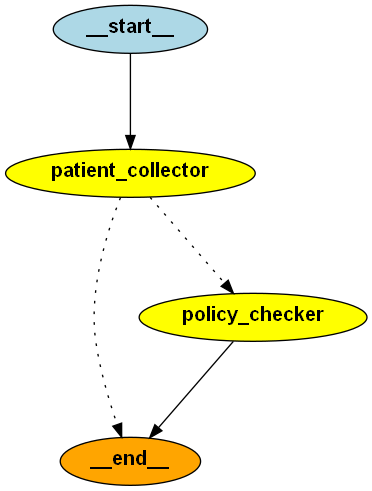

In [103]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.pydantic_v1 import BaseModel

# model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost

memory = SqliteSaver.from_conn_string(":memory:")



# ------- Agents:
class Patient_ID(BaseModel):
    patient_id: int
    # no_id: bool

# model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)  #reduce inference cost
patient_data_prompt = """You are a helpful assistance in extrcting patient's medical history.
Based on the following request identify and return the patient's ID number.
"""
# If you cannot find patient ID in the request text then return 10000 as response.

def patient_collector_node(state: AgentState):
    response = model.with_structured_output(Patient_ID).invoke([
        SystemMessage(content=patient_data_prompt),
        HumanMessage(content=state['patient_prompt'])
    ])
    patient_id = response.patient_id
    print(response)
    print(f"Patient ID: {patient_id}")
    result = get_patient_data(patient_id)
    
    return {
        "patient_data": result,
        "patient_id": patient_id,
        "revision_number": state.get("revision_number", 1) + 1
        }

# Define the agent state structure
# class NewPatientData(TypedDict):
#     name: str
#     age: int
#     medical_history: str
#     previous_trials: str
#     trial_status: str
#     last_trial_dates: str


# def patient_adder_node(state: AgentState):
#     # x= input("Enter patient data: ")
#     # print(x)
#     add_patient_data(
#         {"name": "John Doe", 
#         "age": 45, 
#         "medical_history": "Hypertension", 
#         "previous_trials": "Trial 15", 
#         "trial_status": "Completed", 
#         "last_trial_dates": "2021-06-14"}
#         )
#     print('patient added')    

def policy_checker(state: AgentState):
    # Convert patient_data to string
    
    parser = StrOutputParser()
    prompt_profile = PromptTemplate(
        template="""
        You are the Clinical Research Coordinator. Use the following patient data to write the patient profile.
        Write the patient profile in 3 to 4 sentences.\n\n
        {patient_data}""",
        input_variables=["patient_data"],
    )
    # model = ChatOpenAI(temperature = 0.0, model=modelID)

    chain_profile = prompt_profile | model | parser
    patient_data = state['patient_data']
    patient_profile = chain_profile.invoke({'patient_data': patient_data})
    # nprint(patient_profile)
            
    question = f"""
    Does the following patient profile comply with the institutional policies?\n
    {patient_profile}
    """

    class comply(BaseModel):
            """Binary score for trial eligibility check."""

            binary_score: str = Field(description="Patient eligible for the clinical trial 'yes' or 'no'")
            reason: str = Field(description="Reason(s) only if the patient is not eligible for clinical trials. Othereise use NA")
            
    # model = ChatOpenAI(temperature = 0.0, model=modelID)
    llm_with_tool = model.with_structured_output(comply)
    
    docs_retrieved = retriever.get_relevant_documents(question)
    # docs_retrieved
    docs = "\n\n".join(doc.page_content for doc in docs_retrieved)
    # docs

    prompt_policy = PromptTemplate(
        template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
        Use the following pieces of retrieved context from the institution's policies to answer the question about the patient's eligibility. 
        Here are the retrieved policies: \n\n {context} \n\n
        Here is the user question: {question} \n
        Today is {date}\n
        Give a reason only to rejection cases.
        Give a binary score 'yes' or 'no' score to indicate whether the patient is eligible for clinical trials.""",
        input_variables=["context", "question"],
    )

    date = datetime.now().strftime("%Y-%m-%d")
    
    chain = ( 
        {"patient_profile" : chain_profile, "question" : itemgetter('question'),
        "context" : itemgetter('context'), "date" : itemgetter('date')} | prompt_policy | llm_with_tool
    )

    scored_result = chain.invoke(
        {
            "question": question, 
            "context": docs, 
            "date": date, 
            "patient_data": patient_data
        }
    )
    
    # scored_result    
    state['policy_eligible'] = True
    if scored_result.binary_score == 'no':
        state['policy_eligible'] = False    
        state['rejection_reason'] = scored_result.reason
    
    state['policies'] = docs_retrieved
    state['patient_profile'] = patient_profile

    return state

def should_continue(state: AgentState):
    end = False
    if state.get("patient_data"):
        print('patient data found')
        print(state.get("patient_data"))
        return "policy_checker"
    else:
        print('patient data not found')
        return END
        
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')
        # print(state.get("patient_data", 1))
        return END        


# ==== define graph nodes====
from langgraph.graph import StateGraph, END

builder = StateGraph(AgentState)
builder.set_entry_point("patient_collector")

builder.add_node("patient_collector", patient_collector_node)
builder.add_node("policy_checker", policy_checker)

# retrieve = ToolNode([retriever_tool])
# builder.add_node("retrieve", retrieve)  # retrieval


# ===== define graph edges====
# builder.add_edge("patient_collector", "")
# builder.add_edge("patient_adder", "patient_collector")
builder.add_conditional_edges(
    "patient_collector", 
    should_continue, 
    {END: END
    # "patient_collector": "patient_collector"
    , "policy_checker": "policy_checker"
    # ,"patient_adder": "patient_adder"
    }
)

# builder.add_edge("policy_checker", "retrieve")
# builder.add_conditional_edges(
#     "policy_checker", 
#     tools_condition, 
#     {END: END
#     ,"tools": "retrieve"
#     }
# )

builder.add_edge("policy_checker", END)


graph = builder.compile(
    checkpointer=memory
    # , interrupt_before=["patient_adder"]
)

from IPython.display import Image

Image(graph.get_graph().draw_png())



In [104]:
# patient_data['medical_history'] = "Chronic Pain, Pregnant"
sample_patient_id = 8
patient_data = get_patient_data(sample_patient_id)
# patient_data['trial_completion_date'] = '2024-04-01'
patient_data
# date

{'patient_id': 8,
 'name': 'Daniel Wilson',
 'age': 21,
 'medical_history': 'Cancer',
 'previous_trials': 'Trial 12',
 'trial_status': 'Ongoing',
 'trial_completion_date': None}

In [116]:
thread = {"configurable": {"thread_id": "9"}}
for s in graph.stream({
    'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",
    # 'patient_prompt': "Is patient Max eligible for any medical trial?",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

patient_id=8
Patient ID: 8
patient data found
{'patient_id': 8, 'name': 'Daniel Wilson', 'age': 21, 'medical_history': 'Cancer', 'previous_trials': 'Trial 12', 'trial_status': 'Ongoing', 'trial_completion_date': None}
{'patient_collector': {'patient_id': 8, 'patient_data': {'patient_id': 8, 'name': 'Daniel Wilson', 'age': 21, 'medical_history': 'Cancer', 'previous_trials': 'Trial 12', 'trial_status': 'Ongoing', 'trial_completion_date': None}, 'revision_number': 2}}
{'policy_checker': {'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'policy_eligible': False, 'rejection_reason': 'Patient has a medical history of cancer, currently enrolled in an ongoing trial, and has previously participated in Trial 12. The patient is not eligible for clinical trials due to the medical history and ongoing trial enrollment.', 'patient_data': {'patient_id': 8, 'name': 'Daniel Wilson', 'age': 21, 'medical_history': 'Cancer', 'previous_trials': 'Trial 12', 'trial_status': '

In [124]:
states = []
for state in graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)
state = states[0]
state.values    

StateSnapshot(values={'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'policy_eligible': False, 'rejection_reason': 'History of cancer and previous participation in Trial 12 within an unknown trial status and completion date.', 'patient_data': {'patient_id': 8, 'name': 'Daniel Wilson', 'age': 21, 'medical_history': 'Cancer', 'previous_trials': 'Trial 12', 'trial_status': None, 'trial_completion_date': None}, 'patient_profile': "Patient Profile:\nDaniel Wilson is a 21-year-old individual with a history of cancer. He has previously participated in Trial 12. Currently, Daniel's trial status and trial completion date are unknown. As the Clinical Research Coordinator, I will ensure that Daniel receives the necessary care and support throughout his participation in the clinical trial.", 'revision_number': 2, 'max_revisions': 2, 'policies': [Document(page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between

{'patient_prompt': 'Is patient 8 eligible for any medical trial?',
 'patient_id': 8,
 'policy_eligible': False,
 'rejection_reason': 'History of cancer and previous participation in Trial 12 within an unknown trial status and completion date.',
 'patient_data': {'patient_id': 8,
  'name': 'Daniel Wilson',
  'age': 21,
  'medical_history': 'Cancer',
  'previous_trials': 'Trial 12',
  'trial_status': None,
  'trial_completion_date': None},
 'patient_profile': "Patient Profile:\nDaniel Wilson is a 21-year-old individual with a history of cancer. He has previously participated in Trial 12. Currently, Daniel's trial status and trial completion date are unknown. As the Clinical Research Coordinator, I will ensure that Daniel receives the necessary care and support throughout his participation in the clinical trial.",
 'revision_number': 2,
 'max_revisions': 2,
 'policies': [Document(page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 

In [127]:
for k, v in s.items():
    if k != "__end__":
        print(k)
        print(v)

policy_checker
{'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'policy_eligible': False, 'rejection_reason': 'Patient has a medical history of cancer, currently enrolled in an ongoing trial, and has previously participated in Trial 12. The patient is not eligible for clinical trials due to the medical history and ongoing trial enrollment.', 'patient_data': {'patient_id': 8, 'name': 'Daniel Wilson', 'age': 21, 'medical_history': 'Cancer', 'previous_trials': 'Trial 12', 'trial_status': 'Ongoing', 'trial_completion_date': None}, 'patient_profile': 'Patient 8, Daniel Wilson, is a 21-year-old individual with a medical history of cancer. He has previously participated in Trial 12 and is currently enrolled in an ongoing trial. The trial completion date for Daniel is not yet determined.', 'revision_number': 2, 'max_revisions': 2, 'policies': [Document(page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be betwee

## HIL
To correct Patient's data to pass the eligibility check.

In [125]:
state = states[1]
for k in state:
    print(k)

state.values["patient_data"]['trial_status'] = None
state.values["patient_data"]['previous_trials'] = None
branch_state = graph.update_state(state.config, state.values)
print(branch_state)
# state


print("--------- continue from modified state ---------")
for event in graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

# for event in graph.stream({
#     'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",
#     # 'patient_prompt': "Is patient Max eligible for any medical trial?",
#     "max_revisions": 2,
#     "revision_number": 1,
# }, thread):
#     print(event)

{'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'patient_data': {'patient_id': 8, 'name': 'Daniel Wilson', 'age': 21, 'medical_history': 'Cancer', 'previous_trials': 'Trial 12', 'trial_status': None, 'trial_completion_date': None}, 'revision_number': 2, 'max_revisions': 2}
('policy_checker',)
{'configurable': {'thread_id': '9', 'thread_ts': '1ef30790-4cc6-67ad-8003-cddadf3343fb'}}
{'source': 'update', 'step': 3, 'writes': {'patient_collector': {'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'patient_data': {'patient_id': 8, 'name': 'Daniel Wilson', 'age': 21, 'medical_history': 'Cancer', 'previous_trials': 'Trial 12', 'trial_status': None, 'trial_completion_date': None}, 'revision_number': 2, 'max_revisions': 2}}}
2024-06-22T09:23:00.145553+00:00
{'configurable': {'thread_id': '9', 'thread_ts': '1ef3078d-5a56-60cf-8002-9acd520c48ce'}}
patient data found
{'patient_id': 8, 'name': 'Daniel Wilson', 'age': 21, 'medical

In [47]:
# s.get("patient_collector")
# graph.get_state(thread).next
# graph.get_state_history(thread)
current_state = graph.get_state(thread)
current_state.values["patient_prompt"] = 'Is patient 100 eligible for any medical trial?'
graph.update_state(thread, current_state.values)
# s
# a=10000
# type(a)

patient data not found --> patient_adder_node


{'configurable': {'thread_id': '1',
  'thread_ts': '1ef2f4b1-a2ee-6432-8002-173519ee5347'}}

In [53]:
state = states[2]
state.values["patient_prompt"] = 'Is patient 100 eligible for any medical trial?'
branch_state = graph.update_state(state.config, state.values)
branch_state

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef2f4f7-19d3-601f-8001-87ae15683d5d'}}

In [54]:
for event in graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

patient_id=100
Patient ID: 100
patient data found
{'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}
max revision reached
{'patient_data': {'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}, 'revision_number': 2}


## =========== GPT way ==============

In [3]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

# Define the function that calls the model
def call_model(state):
    # In this simple example, we just pass the patient_id to the tool and get the patient data
    patient_id = state["patient_id"]
    patient_data = retrieve_patient_data_tool(patient_id)
    return {"patient_data": patient_data}

# Define the function that determines whether to continue or not
def should_continue(state):
    if state.get("patient_data"):
        return "end"
    return "continue"

# Initialize the state graph
workflow = StateGraph()

# Add nodes
workflow.add_node("retrieve_patient_data", call_model)

# Set entry point
workflow.set_entry_point("retrieve_patient_data")

# Define conditional edges
workflow.add_conditional_edges(
    "retrieve_patient_data",
    should_continue,
    {"continue": "retrieve_patient_data", "end": END}
)

# Compile the workflow
app = workflow.compile()

# Example invocation
initial_state = {"patient_id": 1}
app.invoke(initial_state)


TypeError: StateGraph.__init__() missing 1 required positional argument: 'state_schema'

## Dummy tests

In [12]:
assert 1==2

     type                  name              tbl_name  rootpage  \
0   table        aircrafts_data        aircrafts_data         2   
1   table         airports_data         airports_data         3   
2   table       boarding_passes       boarding_passes         4   
3   table              bookings              bookings         5   
4   table               flights               flights         6   
5   table                 seats                 seats         7   
6   table        ticket_flights        ticket_flights         8   
7   table               tickets               tickets         9   
8   table           car_rentals           car_rentals     21958   
9   table                hotels                hotels     21961   
10  table  trip_recommendations  trip_recommendations     21962   

                                                  sql  
0   CREATE TABLE "aircrafts_data" (\n"aircraft_cod...  
1   CREATE TABLE "airports_data" (\n"airport_code"...  
2   CREATE TABLE "boarding_

In [ ]:

import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)
# Convert the flights to present time for our tutorial
# local_file = 
conn = sqlite3.connect(local_file)
cursor = conn.cursor()

query = 'SELECT * FROM sqlite_master'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)

# Display the DataFrame
print(df)

In [6]:
tdf

NameError: name 'tdf' is not defined